##### What is this notebook about?
- This notebook shows how to finetune language model using QLoRA -- using BitsandBytes library & hugging face trainer. 
- "distill-bert model" was used as an example. 

##### QLoRA

- QLoRA is an extension of LoRA that leverages quantization
- It reduces memory footprint by using fewer number of bits to store information
- Smaller models => Less resources for training & inference
- Compared to LoRA: Accuracy is usually comparable, Fine tuning speed may increase/decrease depending on hardware

In [1]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
# Set cuda device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Conda env: 
# Setup: conda env create -f environment_mlenv2
# Activate: conda activate mlenv2

In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GenerationConfig,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
    TaskType, 
    replace_lora_weights_loftq,
)
import torch #, wandb
from datasets import load_dataset
import evaluate
import bitsandbytes as bnb

import os
import numpy as np
import json
import matplotlib.pyplot as plt

In [4]:
# from huggingface_hub import login
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
# login(token = hf_token)

# wb_token = user_secrets.get_secret("wandb")
# wandb.login(key=wb_token)
# run = wandb.init(
#     project='Fine-tune Llama 3.2 on Customer Support Dataset', 
#     job_type="training", 
#     anonymous="allow"
# )

In [ ]:
base_model = "distilbert-base-uncased"
new_model = "../output_dir/imdb-cls"
dataset_name = "imdb"

In [6]:
# Load tokenizer
#tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# Load slow tokenizer, fast tokenizer sometimes ignores added tokens
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [7]:
#Importing the dataset
dataset = load_dataset(dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
# Check a sample & check format
sample_text = dataset['train']['text'][3]
sample_label = dataset['train']['label'][3]
print("Sample text:", sample_text)
print("Sample label:", sample_label)

Sample text: This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impressive, undeservedly good, photo. Apart from that, what strikes me most is the endless stream of silliness. Lena Nyman has to be most annoying actress in the world. She acts so stupid and with all the nudity in this film,...it's unattractive. Comparing to Godard's film, intellectuality has been replaced with stupidity. Without going too far on this subject, I would say that follows from the difference in ideals between the French and the Swedish society.<br /><br />A movie of its time, and place. 2/10.
Sample label: 0


In [9]:
# Get all unique labels
train_labels = dataset['train']['label']
unique_labels = set(train_labels)
print(f"Found {len(unique_labels)} unique labels in the dataset:")
print(unique_labels)

Found 2 unique labels in the dataset:
{0, 1}


In [10]:
# Check tokenize
tokenized_sample = tokenizer(sample_text)
print(tokenized_sample)

print(tokenized_sample.keys())
# If token_type_ids is present, print it
if 'token_type_ids' in tokenized_sample:
    print("Token Type IDs:", tokenized_sample['token_type_ids'])

{'input_ids': [101, 2023, 2143, 2001, 2763, 4427, 2011, 2643, 4232, 1005, 1055, 16137, 10841, 4115, 1010, 10768, 25300, 2078, 1998, 1045, 9075, 2017, 2000, 2156, 2008, 2143, 2612, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 2143, 2038, 2048, 2844, 3787, 1998, 2216, 2024, 1010, 1006, 1015, 1007, 1996, 12689, 3772, 1006, 1016, 1007, 1996, 8052, 1010, 6151, 6810, 2099, 7178, 2135, 2204, 1010, 6302, 1012, 4237, 2013, 2008, 1010, 2054, 9326, 2033, 2087, 2003, 1996, 10866, 5460, 1997, 9033, 21202, 7971, 1012, 14229, 6396, 2386, 2038, 2000, 2022, 2087, 15703, 3883, 1999, 1996, 2088, 1012, 2016, 4490, 2061, 5236, 1998, 2007, 2035, 1996, 16371, 25469, 1999, 2023, 2143, 1010, 1012, 1012, 1012, 2009, 1005, 1055, 14477, 4779, 26884, 1012, 13599, 2000, 2643, 4232, 1005, 1055, 2143, 1010, 7789, 3012, 2038, 2042, 2999, 2007, 28072, 1012, 2302, 2183, 2205, 2521, 2006, 2023, 3395, 1010, 1045, 2052, 2360, 2008, 4076, 2013, 1996, 4489, 1999, 15084, 2090, 1996, 2413, 1998, 1996, 4467, 2554

In [11]:
# Preproces function
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

In [12]:
# Check sample prompt templates
sample_text = dataset['train']['text'][3]
sample_label = dataset['train']['label'][3]
train_sample = {"text": sample_text, 
                "label": sample_label}
sample_text_tokenized = preprocess_function(train_sample)
print("Sample train tokenized:\n", sample_text_tokenized)

Sample train tokenized:
 {'input_ids': [101, 2023, 2143, 2001, 2763, 4427, 2011, 2643, 4232, 1005, 1055, 16137, 10841, 4115, 1010, 10768, 25300, 2078, 1998, 1045, 9075, 2017, 2000, 2156, 2008, 2143, 2612, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 2143, 2038, 2048, 2844, 3787, 1998, 2216, 2024, 1010, 1006, 1015, 1007, 1996, 12689, 3772, 1006, 1016, 1007, 1996, 8052, 1010, 6151, 6810, 2099, 7178, 2135, 2204, 1010, 6302, 1012, 4237, 2013, 2008, 1010, 2054, 9326, 2033, 2087, 2003, 1996, 10866, 5460, 1997, 9033, 21202, 7971, 1012, 14229, 6396, 2386, 2038, 2000, 2022, 2087, 15703, 3883, 1999, 1996, 2088, 1012, 2016, 4490, 2061, 5236, 1998, 2007, 2035, 1996, 16371, 25469, 1999, 2023, 2143, 1010, 1012, 1012, 1012, 2009, 1005, 1055, 14477, 4779, 26884, 1012, 13599, 2000, 2643, 4232, 1005, 1055, 2143, 1010, 7789, 3012, 2038, 2042, 2999, 2007, 28072, 1012, 2302, 2183, 2205, 2521, 2006, 2023, 3395, 1010, 1045, 2052, 2360, 2008, 4076, 2013, 1996, 4489, 1999, 15084, 2090, 1996, 241

In [13]:
# Select subset of data for train/test & format prompt template 
def data_prep(dataset, subset_type):
    dataset_subset = dataset[subset_type].shuffle(seed=65).select(range(5000))
    #dataset_subset = dataset[subset_type].select(range(5000))
    dataset_subset = dataset_subset.map(preprocess_function, num_proc= 4, batched=True)
    print(dataset_subset)
    print(f"Check a {subset_type} sample:")
    print(dataset_subset[3])
    print(dataset_subset['label'][3])
    return dataset_subset

train_data = data_prep(dataset, 'train')
test_data = data_prep(dataset, 'test')


Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5000
})
Check a train sample:
{'text': "I was pleasantly surprised by the film. Let's face it; the premise doesn't sound particularly appealing when having to hand over money for a the night's flick, but it had an easygoing nature that wins one over. There were no moments that I found uproarious, and I doubt any that I'll remember the next day, but this doesn't fail as a nice diversion. What I found funny was watching it here in Peking with my Chinese girlfriend who never understands anything I like. I told her there was a plot- three guys have to bring back some weed to London. Hardly satisfying for her. There is no mugging going on here for the camera which I'd been expecting after reading a number of the comments. I do take exception however to comparisons with Withnail and I; not in the same league, and I doubt was it intended to. www.imperialflags.blogspot.com", 'label': 1, 'input_ids': [101, 1

In [14]:
# Sanity check
train_data

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5000
})

In [15]:
# Load model

# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"
print(torch_dtype, attn_implementation)

# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                  # quantize the model to 4-bits when you load it
    bnb_4bit_quant_type="nf4",          # use a special 4-bit data type for weights initialized from a normal distribution
    bnb_4bit_compute_dtype=torch_dtype, # use bfloat16 for faster computation
    bnb_4bit_use_double_quant=True,     # nested quantization scheme to quantize the already quantized weights
    llm_int8_skip_modules=["classifier", "pre_classifier"] #  Don't convert the "classifier" and "pre_classifier" layers to 8-bit
)

# Give labels to classes
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = dict((v,k) for k,v in id2label.items())

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label,
    label2id=label2id,
    num_labels=2,
    quantization_config=bnb_config,
    #device_map="auto",
    #attn_implementation=attn_implementation
)

torch.bfloat16 flash_attention_2


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Linear layers are converted to Linear4bit layers. These use blockwise k-bit quantization under the hood
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear4bit(in_features=768, out_features=768, bias=True)
            (k_lin): Linear4bit(in_features=768, out_features=768, bias=True)
            (v_lin): Linear4bit(in_features=768, out_features=768, bias=True)
            (out_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1,

In [17]:
# Prepare the model for quantized training
model = prepare_model_for_kbit_training(model)

In [18]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear4bit(in_features=768, out_features=768, bias=True)
            (k_lin): Linear4bit(in_features=768, out_features=768, bias=True)
            (v_lin): Linear4bit(in_features=768, out_features=768, bias=True)
            (out_lin): Linear4bit(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1,

In [19]:
# Get modules for LoRA
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            #print(name)
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
modules = find_all_linear_names(model)
print(modules)

['out_lin', 'q_lin', 'v_lin', 'lin1', 'k_lin', 'lin2']


In [20]:
# LoRA config
peft_config = LoraConfig(
    r=8,                                        # Rank of the low-rank matrices
    lora_alpha=16,                              # Scaling factor
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,                  # instead of "CAUSAL_LM",
    target_modules=['q_lin','k_lin','v_lin']   # could be all "modules"
)
model = get_peft_model(model, peft_config)

In [21]:
# Re-initialize the LoRA weights using LoftQ
replace_lora_weights_loftq(model)

In [22]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_fea

In [23]:
# Only 1% of parameters will be trained
model.print_trainable_parameters()

trainable params: 813,314 || all params: 67,768,324 || trainable%: 1.2001


In [24]:
#Hyperparamter
training_arguments = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    #gradient_accumulation_steps=1, #2,
    #optim="paged_adamw_32bit",
    num_train_epochs=8,
    eval_strategy="epoch",
    #eval_steps=0.2,
    #logging_steps=1,
    #warmup_steps=10,
    #logging_strategy="steps",
    learning_rate=2e-5,
    #fp16=False,
    #bf16=False,
    #group_by_length=True,
    #report_to="wandb"
    #report_to="tensorboard",
    weight_decay=0.01
)


In [25]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy", trust_remote_code=True)
 
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}


In [26]:
# Setting sft parameters
trainer = Trainer( 
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    #peft_config=peft_config,
    #max_seq_length= 512,
    #dataset_text_field="text",
    tokenizer=tokenizer,
    #data_collator=collate,
    args=training_arguments,
    #packing= False,
    compute_metrics=compute_metrics
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [27]:
# Disable caching k, v. Its on by default in model config. Not useful for training, only needed for generation
# model.config.use_cache = False

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.389577,0.855200
2,0.503600,0.307561,0.871600
3,0.503600,0.297783,0.876200
4,0.307900,0.292212,0.879400
5,0.280100,0.288328,0.883600
6,0.280100,0.286440,0.883200
7,0.262900,0.286997,0.884800
8,0.276000,0.284190,0.885400


TrainOutput(global_step=2504, training_loss=0.3258430707854585, metrics={'train_runtime': 284.7791, 'train_samples_per_second': 140.46, 'train_steps_per_second': 8.793, 'total_flos': 5398635970560000.0, 'train_loss': 0.3258430707854585, 'epoch': 8.0})

In [28]:
#wandb.finish()

# Enable caching
#model.config.use_cache = True

# Save the fine-tuned model
#trainer.model.save_pretrained(new_model)
trainer.save_model(new_model)

#trainer.model.push_to_hub(new_model, use_temp_dir=False)

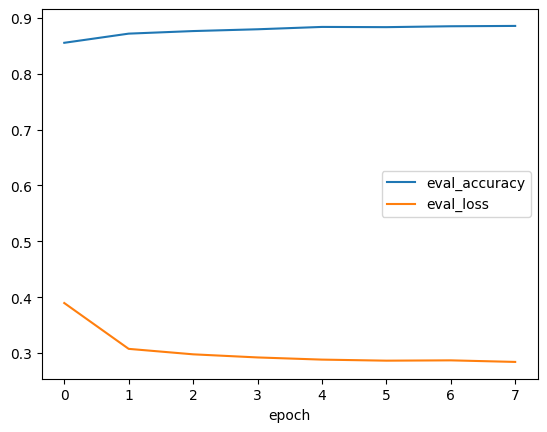

In [ ]:
# Plot eval accuracy & loss

log_history = trainer.state.log_history
get_metric = lambda metric, log_history: [log[metric] for log in log_history if metric in log]

eval_accuracy = get_metric('eval_accuracy',log_history)
eval_loss = get_metric('eval_loss',log_history)

plt.plot(eval_accuracy,label='eval_accuracy')
plt.plot(eval_loss,label='eval_loss')
plt.xlabel("epoch")
plt.legend()

In [ ]:
# ## Run inference

# TBD

# # Test input
# test_sample = 

# # Tokenize input 
# inputs = tokenize(test_sample).to("cuda")

# # Generate model output
# #outputs = model(**inputs)

# # Decode
# text = tokenizer.decode(outputs[0], skip_special_tokens=True)

### References:

> https://www.coursera.org/specializations/generative-ai-engineering-with-llms  
> LoftQ: https://arxiv.org/abs/2310.08659

> https://huggingface.co/docs/transformers/en/quantization/bitsandbytes#4-bit-qlora-algorithm  
> https://huggingface.co/blog/4bit-transformers-bitsandbytes  
> https://huggingface.co/blog/hf-bitsandbytes-integration  
> https://en.wikibooks.org/wiki/A-level_Computing/AQA/Paper_2/Fundamentals_of_data_representation/Floating_point_numbers#:~:text=In%20decimal%2C%20very%20large%20numbers,be%20used%20for%20binary%20numbers 

> https://huggingface.co/docs/transformers/main/en/chat_templating 

> https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/trainer#transformers.TrainingArguments  
> https://huggingface.co/docs/peft/v0.14.0/en/task_guides/lora_based_methods  
> https://huggingface.co/docs/peft/main/en/developer_guides/checkpoint  
